# 📝 1 อธิบายภาพรวม

1. โหลดชุดข้อมูล cleaned_all_rooms.xlsx

2. เลือกฟีเจอร์ (department, duration_hours, event_period, price, seats) และ Target (room)

3. แบ่ง Train/Test เป็น 80 : 20

4. สร้าง Pipeline พร้อม Pre-processing

5. เทรนและประเมินโมเดล Decision Tree, SVM, KNN

6. แสดง Accuracy และ Classification Report


# 🔥 1 โหลดไลบรารีและข้อมูล


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# โหลดข้อมูล
df = pd.read_excel('/content/cleaned_all_rooms.xlsx')

# ฟีเจอร์ที่ต้องการใช้
feature_cols = ['department', 'duration_hours', 'price', 'event_period', 'seats']
target_col   = 'room'

X = df[feature_cols]
y = df[target_col]

# ตรวจจำนวนตัวอย่างต่อห้อง
vc = y.value_counts()

# เก็บเฉพาะห้องที่มี >= 2 รายการจอง
valid_rooms = vc[vc >= 2].index
mask = y.isin(valid_rooms)

X_filt = X[mask]
y_filt = y[mask]

# 📝 2 แบ่ง Train/Test (80 : 20)

- ใช้ `train_test_split(test_size = 0.2, random_state = 42, stratify = y)`
  เพื่อรักษาสัดส่วนคลาสของ `room` ในชุด Train และ Test


In [7]:
# แบ่ง 80:20 พร้อม stratify ได้แล้ว
X_train, X_test, y_train, y_test = train_test_split(
    X_filt, y_filt,
    test_size=0.20,
    random_state=42,
    stratify=y_filt
)

#📝 3 เตรียม Pre-processing Pipeline

- ฟีเจอร์ตัวเลข (`duration_hours`, `price, seats`) 👉 ปรับสเกลด้วย `StandardScaler`

- ฟีเจอร์ประเภทหมวดหมู่ (`department`, `event_period`) 👉 เข้ารหัส One-Hot

- รวมด้วย `ColumnTransformer` เพื่อให้จ่ายเข้าโมเดลได้โดยตรง


In [8]:
num_cols = ['duration_hours', 'seats']
cat_cols = ['department', 'event_period']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# 📝 4 สร้างและอธิบายโมเดลพร้อม Hyper-parameters

| โมเดล             | Hyper-parameter สำคัญ (ตัวอย่าง)                                                          | เหตุผลที่เลือก                                                                                        |
| ----------------- | ----------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------- |
| **Decision Tree** | `criterion='entropy'`, `max_depth=None`, `min_samples_split=2`, `class_weight='balanced'` | ใช้ Entropy เหมือน C4.5, เปิดให้ต้นไม้แตกกิ่งเต็มที่ และถ่วงน้ำหนักคลาสเพื่อลด bias                   |
| **SVM**           | `kernel='rbf'`, `C=10`, `gamma='scale'`, `class_weight='balanced'`                        | RBF เหมาะกับข้อมูลไม่เชิงเส้น, กำหนด C=10 ให้ margin แคบขึ้น และปรับ class weight ให้ข้อมูลไม่บาลานซ์ |
| **KNN**           | `n_neighbors=5`, `weights='distance'`, `metric='minkowski'`, `p=2`                        | ใช้เพื่อนบ้าน 5 จุด, ถ่วงน้ำหนักตามระยะทาง, ระยะ Euclidean (Minkowski p=2)                            |


In [ ]:
# =========================================
# 1) โมเดลใหม่ “ลดความซับซ้อน” (Simpler Models)
# =========================================
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

simple_models = {
    'Decision Tree (depth=6)': DecisionTreeClassifier(
        criterion='entropy',
        max_depth=4,             
        min_samples_leaf=12,     
        ccp_alpha=0.005,         
        class_weight='balanced',
        random_state=42
    ),
    'SVM (RBF)': SVC(
        kernel='rbf',
        C=70,
        gamma=0.5,
        class_weight='balanced',
        random_state=42
    ),
    'KNN (k=15)': KNeighborsClassifier(
        n_neighbors=15,          # เพิ่มจำนวนเพื่อนบ้าน
        weights='distance',
        metric='minkowski',
        p=2
    )
}

summary = []

for name, clf in simple_models.items():
    pipe = Pipeline([('prep', preprocess),
                     ('clf',  clf)])
    pipe.fit(X_train, y_train)

    # ==== Train / Test accuracy ====
    train_acc = accuracy_score(y_train, pipe.predict(X_train))
    test_acc  = accuracy_score(y_test,  pipe.predict(X_test))

    print(f'\n### {name} ###')
    print(f'Train acc : {train_acc:.3f}')
    print(f'Test  acc : {test_acc:.3f}')
    print(classification_report(y_test, pipe.predict(X_test)))

    summary.append({
        'Model'      : name,
        'Train_Acc.' : round(train_acc, 3),
        'Test_Acc.'  : round(test_acc, 3),
        'Gap'        : round(train_acc - test_acc, 3)   # ช่องว่างระหว่าง train / test
    })

# =========================================
# 2) บันทึกผลลง Excel
# =========================================
result_df = pd.DataFrame(summary)
with pd.ExcelWriter('/content/model_results_reduced.xlsx') as writer:
    result_df.to_excel(writer, sheet_name='Accuracy', index=False)

print('บันทึกสรุปผล → /content/model_results.xlsx')
result_df



### Decision Tree (depth=6) ###
Train acc : 0.989
Test  acc : 0.984
                       precision    recall  f1-score   support

             หอประชุม       1.00      1.00      1.00        89
         ห้องประชุม 1       1.00      1.00      1.00        35
       ห้องประชุม 317       1.00      1.00      1.00        48
    ห้องประชุม 317 บน       0.75      0.21      0.33        14
  ห้องประชุม 317 ล่าง       0.15      0.67      0.25         3
      ห้องประชุม สนอ.       1.00      1.00      1.00         5
ห้องประชุมบ้านพลูหลวง       1.00      1.00      1.00         9
       อยุธยา-อาเซียน       1.00      1.00      1.00       232
       อยุธยา-ฮอลันดา       1.00      1.00      1.00       101
      อยุธยา-โปรตุเกส       1.00      1.00      1.00       200

             accuracy                           0.98       736
            macro avg       0.89      0.89      0.86       736
         weighted avg       0.99      0.98      0.98       736


### SVM (RBF) ###
Train acc : 0.937
Test  acc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



### KNN (k=15) ###
Train acc : 1.000
Test  acc : 0.938
                       precision    recall  f1-score   support

             หอประชุม       1.00      1.00      1.00        89
         ห้องประชุม 1       0.93      0.77      0.84        35
       ห้องประชุม 317       0.90      0.96      0.93        48
    ห้องประชุม 317 บน       0.82      0.64      0.72        14
  ห้องประชุม 317 ล่าง       0.00      0.00      0.00         3
      ห้องประชุม สนอ.       0.80      0.80      0.80         5
ห้องประชุมบ้านพลูหลวง       1.00      0.56      0.71         9
       อยุธยา-อาเซียน       0.95      0.96      0.95       232
       อยุธยา-ฮอลันดา       0.94      0.95      0.95       101
      อยุธยา-โปรตุเกส       0.91      0.96      0.94       200

             accuracy                           0.94       736
            macro avg       0.83      0.76      0.78       736
         weighted avg       0.93      0.94      0.93       736

บันทึกสรุปผล → /content/model_results.xlsx


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Train_Acc.,Test_Acc.,Gap
0,Decision Tree (depth=6),0.989,0.984,0.005
1,SVM (RBF),0.937,0.908,0.029
2,KNN (k=15),1.000,0.938,0.062


# 🎨 การ Plot Graph


In [10]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# -------- 1) Encode labels --------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# -------- 2) Transform features (preprocess + PCA 2-D) --------
pca = PCA(n_components=2, random_state=42)
X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

X_train_pca = pca.fit_transform(X_train_prep)
X_test_pca  = pca.transform(X_test_prep)

print("✨ PCA shape  :", X_train_pca.shape)
print("✨ #Classes   :", len(le.classes_))


✨ PCA shape  : (2941, 2)
✨ #Classes   : 10


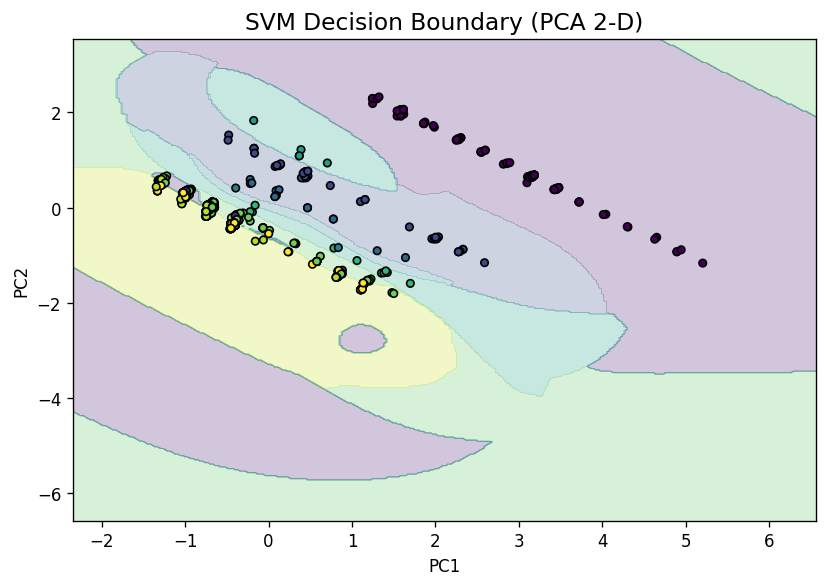

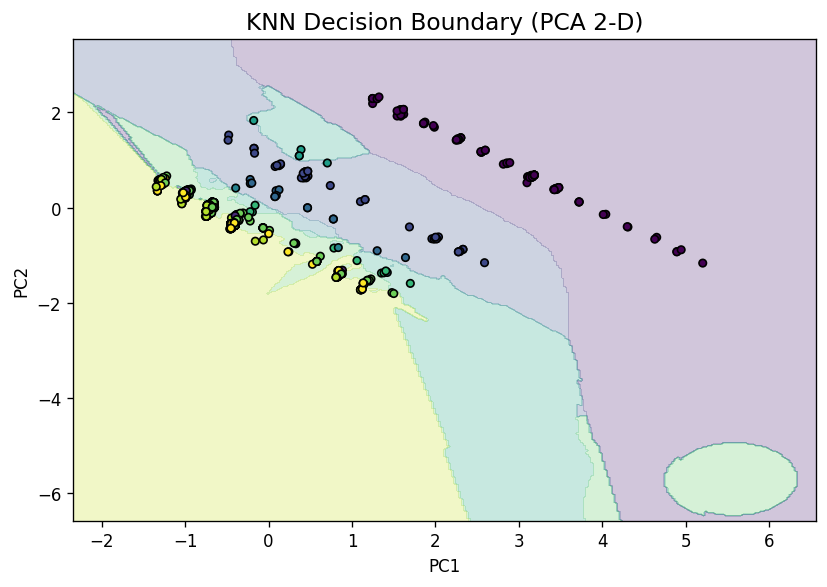

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# ---------- ฟังก์ชันวาด boundary ----------
def plot_boundary(clf, X_pca, y_enc, title):
    h = .03
    x_min, x_max = X_pca[:, 0].min()-1, X_pca[:, 0].max()+1
    y_min, y_max = X_pca[:, 1].min()-1, X_pca[:, 1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(7, 5), dpi=120)
    ax.contourf(xx, yy, Z, alpha=0.25)             # ใช้สี default
    ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1],
               c=y_test_enc, edgecolors='k', s=20)  # default colormap

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
    plt.tight_layout()
    plt.show()

# ---------- 1) SVM ----------
svm_best = simple_models['SVM (RBF)']
svm_2d = SVC(kernel='rbf', C=svm_best.C, gamma=svm_best.gamma,
            class_weight='balanced', random_state=42)
svm_2d.fit(X_train_pca, y_train_enc)
plot_boundary(svm_2d, X_train_pca, y_train_enc, 'SVM Decision Boundary (PCA 2-D)')

# ---------- 2) KNN ----------
knn_best = simple_models['KNN (k=15)']
knn_2d = KNeighborsClassifier(n_neighbors=knn_best.n_neighbors,
                              weights=knn_best.weights)
knn_2d.fit(X_train_pca, y_train_enc)
plot_boundary(knn_2d, X_train_pca, y_train_enc, 'KNN Decision Boundary (PCA 2-D)')


In [12]:
# 1) ติดตั้ง graphviz + pydotplus
!apt-get update -qq
!apt-get install -y -qq graphviz
!pip install -q pydotplus

# 2) ติดตั้งฟอนต์ไทย (Noto Sans Thai UI)
!wget -q https://raw.githubusercontent.com/google/fonts/main/ofl/notosansthaiui/static/NotoSansThaiUI-Regular.ttf
!mkdir -p ~/.fonts && mv NotoSansThaiUI-Regular.ttf ~/.fonts/
!fc-cache -f -v

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
mv: cannot stat 'NotoSansThaiUI-Regular.ttf': No such file or directory
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/opentype/noto: caching, new cache contents: 80 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/noto: caching, new cache contents: 2380 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/opentype

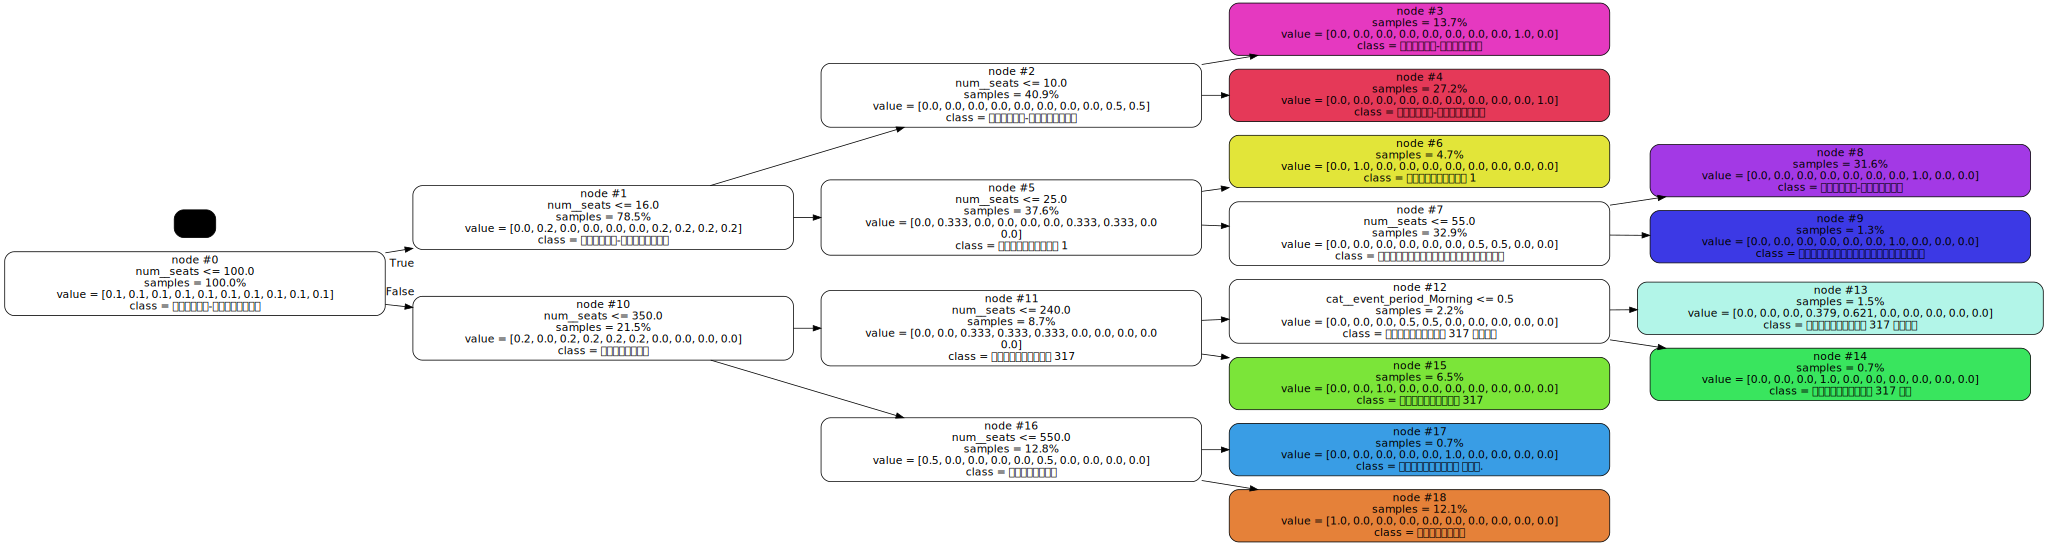

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import Pipeline
import pydotplus, matplotlib as mpl
from IPython.display import SVG

# ฟีเจอร์หมวดตัวเลข / หมวดหมู่
num_cols = ['duration_hours', 'seats']
cat_cols = ['department', 'event_period']

preprocess_raw = ColumnTransformer([
    ('num', 'passthrough', num_cols),                       # << ไม่ Standardize
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

dt_raw = DecisionTreeClassifier(
    criterion='entropy', max_depth=4,
    min_samples_leaf=12, ccp_alpha=0.005,
    class_weight='balanced', random_state=42
)

dt_raw_pipe = Pipeline([('prep', preprocess_raw),
                        ('clf',  dt_raw)])
dt_raw_pipe.fit(X_train, y_train)

# -------------------------------------------------
# 2) Export graphviz ด้วย font ไทย
# -------------------------------------------------
feat_names = dt_raw_pipe.named_steps['prep'].get_feature_names_out()
dot_raw = export_graphviz(
    dt_raw_pipe.named_steps['clf'], out_file=None,
    feature_names = feat_names,
    class_names   = le.classes_,
    filled=True, rounded=True, proportion=True,
    node_ids=True, impurity=False,
    fontname='Noto Sans Thai UI'
)

graph_raw = pydotplus.graph_from_dot_data(dot_raw)
graph_raw.set_graph_defaults(rankdir='LR')        # จัด layout แนวนอน

# (ไม่บังคับ) บันทึกไฟล์
graph_raw.write_png('/content/decision_tree_raw.png')
graph_raw.write_svg('/content/decision_tree_raw.svg')

# แสดงในโน้ตบุ๊ก
SVG(graph_raw.create_svg())


In [14]:
# ----------------------------------------------------------
# 1) เตรียม DataFrame (summary สร้างจากโค้ดเดิม)
# ----------------------------------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

acc_df = pd.DataFrame(summary)      # มีคอลัมน์: Model, Train_Acc., Test_Acc.

# Melt ให้อยู่ในรูป Long-form → seaborn ใช้ hue ได้ง่าย
plot_df = acc_df.melt(id_vars='Model',
                      value_vars=['Train_Acc.', 'Test_Acc.'],
                      var_name='Dataset',
                      value_name='Accuracy')

# ----------------------------------------------------------
# 2) ตั้งค่ารูปแบบ Seaborn
# ----------------------------------------------------------
sns.set_style('whitegrid')                            # Grid ขาวสวย
sns.set_context('talk')                               # ขนาดตัวอักษรเหมาะ presentation
palette = sns.color_palette('Set2', n_colors=2)       # สีสุภาพ

# ----------------------------------------------------------
# 3) สร้าง Bar plot
# ----------------------------------------------------------
plt.figure(figsize=(15, 10), dpi=640)
ax = sns.barplot(
    data=plot_df,
    x='Model', y='Accuracy', hue='Dataset',
    palette=palette
)

# 4) ใส่ค่าบนแท่ง
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

# 5) ตกแต่งเพิ่มเติม
ax.set_ylim(0, 1.05)
ax.set_xlabel('')
ax.set_ylabel('Accuracy')
ax.set_title('Train vs Test Accuracy (Seaborn)', fontsize=18)
ax.legend(title='Dataset', loc='upper right')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
